# Time Series Forecasting
## Using Machine Learning to Forecast Energy Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv', index_col='Datetime', parse_dates=True)
#df = df.set_index('Datetime')
#df.index = pd.to_datetime(df.index)
df.head(5)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


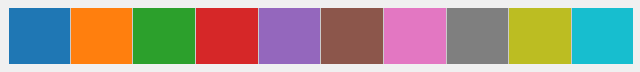

In [3]:
# Our default pallet
sns.palplot(color_pal)
plt.show()



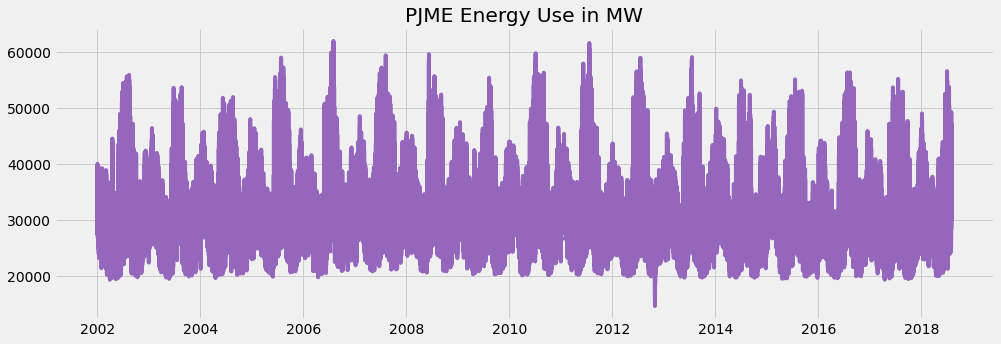

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(df, c=color_pal[4])
plt.title('PJME Energy Use in MW')
plt.show()

## Analysing the plot
#### We can see that in 2013 values are very low in compare to others, wich can be cansidered maybe as an outlire  

<AxesSubplot:ylabel='Frequency'>

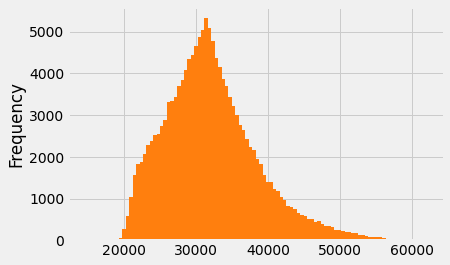

In [5]:
df['PJME_MW'].plot(kind='hist', bins=100, color=color_pal[1])


<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

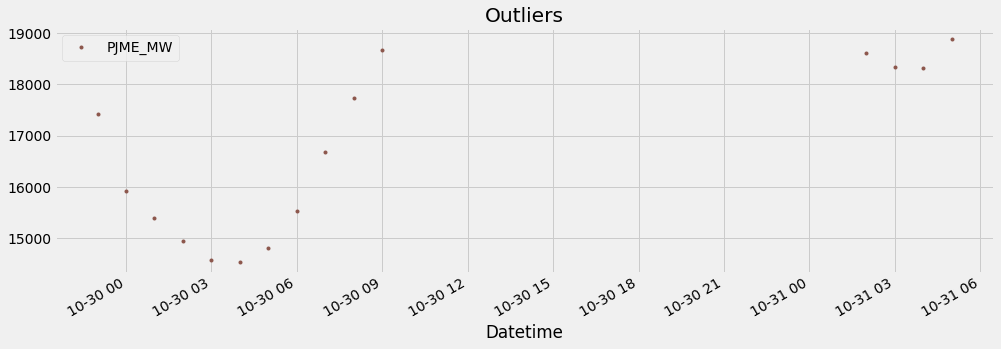

In [6]:
df[df['PJME_MW'] < 19_000]\
        .plot(style='.',figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [7]:
# we create a new dataframe that containes lines whrer PJME above 19000 (we eliminate oulieres)
df = df[df['PJME_MW'] > 19_000]

In [8]:
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


# 1. Time Series Cross Validation¶


In [9]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [10]:
df


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


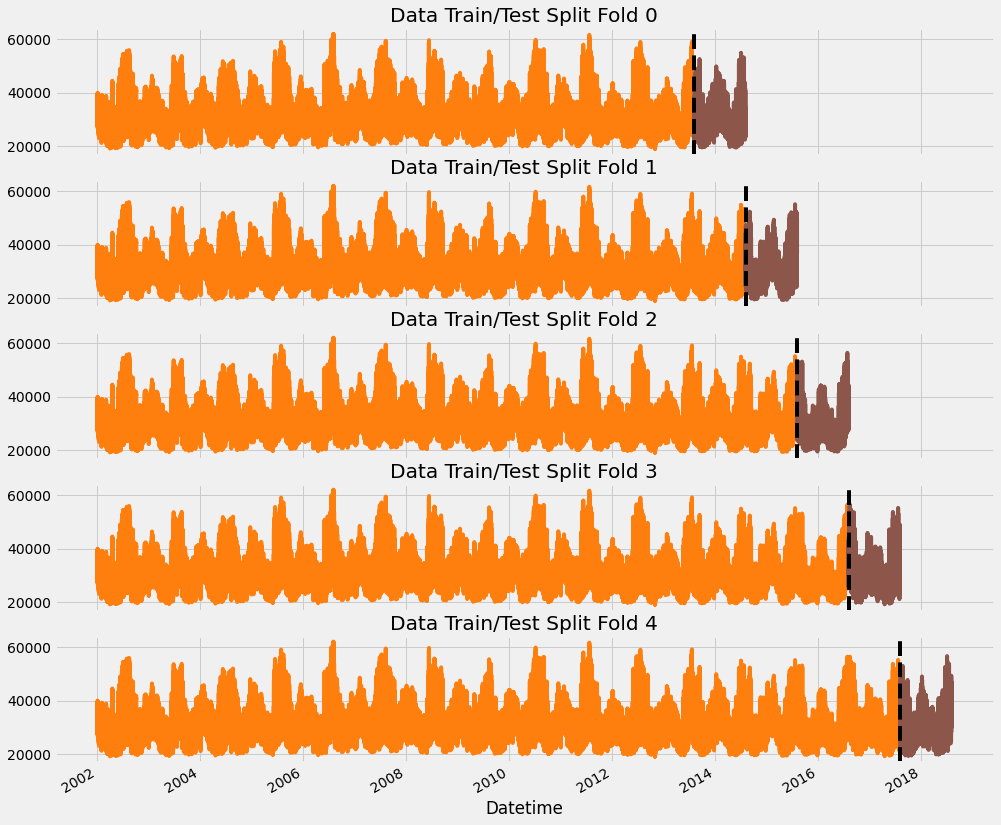

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',
                         color=color_pal[1])
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set', color=color_pal[5])
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

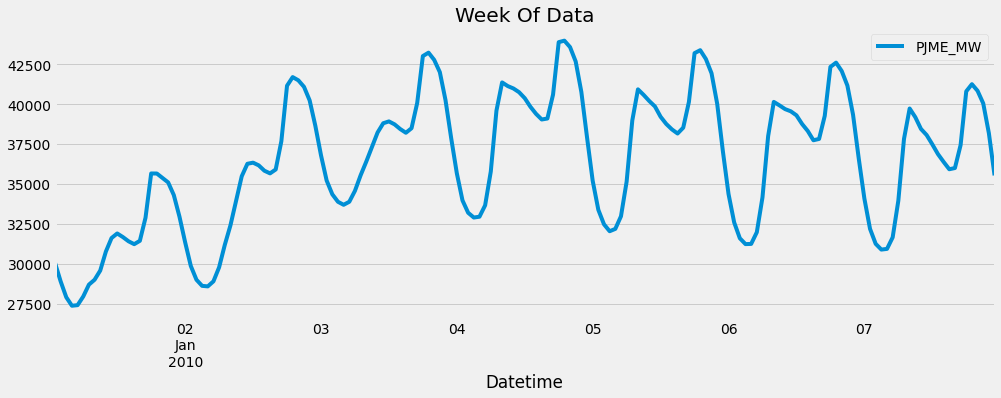

In [12]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# 3- Feature Creation

In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar

def create_features(df):
    """
    Create time series features based on time series index.
    """
    
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df.index.min(), end=df.index.max()) #holiday effects and special event
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_holiday'] = df.index.isin(holidays).astype(int)
    df['is_weekend'] =  df['dayofweek'].isin([5, 6]).astype(int)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] =  df['dayofweek'].isin([5, 6]).astype(int)
    return df

df = create_features(df)

# 4. Lag Features
- What was the target (x) days in the past.

In [14]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) #we use 364 instead of 365 => 363/7 = 52 
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [15]:
df = add_lags(df)
df

,PJME_MW,hour,dayofweek,is_holiday,is_weekend,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,0,0,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,0,0,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,0,0,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,0,0,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,0,0,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,0,0,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,0,0,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,0,0,3,8,2018,214,2,31,39525.0,38698.0,37330.0


# 5. Visualize our Feature / Target Relationship

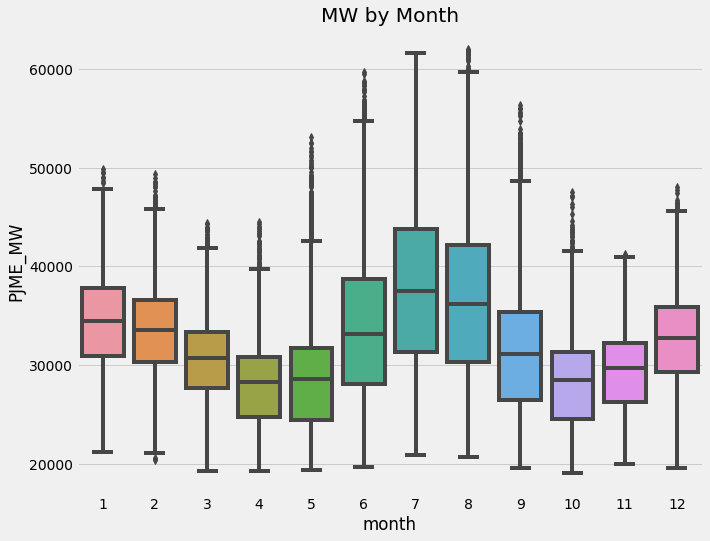

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

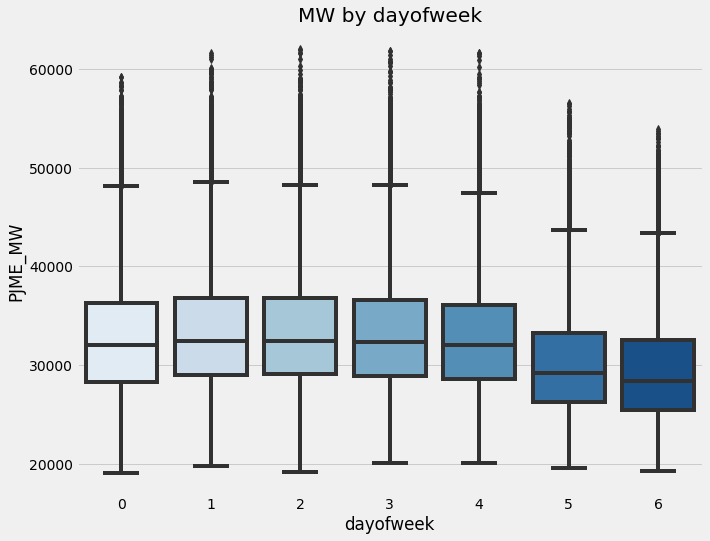

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='PJME_MW', palette='Blues')
ax.set_title('MW by dayofweek')
plt.show()

### We can say that the energy consumption decreases in the weekend

# 6. Train Using Cross Validation

In [18]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'is_holiday', 'is_weekend', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1',
       'lag2', 'lag3'],
      dtype='object')

In [19]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','is_holiday', 'is_weekend',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[19:49:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[450]	validation_0-rmse:3356.42691	validation_1-rmse:3762.64793
[19:49:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.56552	validation_1-rmse:5655.33259
[300]	validation_0-rmse:3904.98895	validation_1-rmse:3931.65967
[400]	validation_0-rmse:3476.76871	validation_1-rmse:3598.75393
[500]	validation_0-rmse:3355.49568	validation_1-rmse:3

In [20]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3753.5994
Fold scores:[3757.485267269142, 3422.628654218696, 3473.0621874794947, 4115.966281700851, 3998.8545666889618]


In [21]:
np.std(y_train)**2


42031279.14373663

# 7. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [22]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500, #we chose 500 instead of 1000 as used previously is because we saw that after 500 the model start to overfit
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[19:51:54] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [23]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [24]:
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [25]:
future_w_features = df_and_future.query('isFuture').copy()

# 8. Predict the future

In [26]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

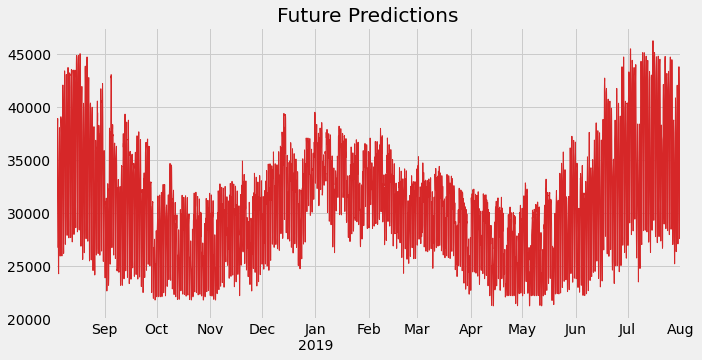

In [27]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [28]:
import joblib

# Sauvegarde le modèle dans un fichier
joblib.dump(reg, 'model.pkl')


['model.pkl']